In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import xarray as xr
import preprocess as pp
import util

import xskillscore as xs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

# Progress bar for dask stuff
from dask.diagnostics import ProgressBar
ProgressBar().register()

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams.update({'font.size': 16})

In [4]:
plot_varnames = ["tas", "pr", "psl"]
timeslice = slice('1981', '2010')

### Load interim data

In [5]:
obs = xr.open_zarr("../data/interim/era5").load()
obs["nino34"] = obs["enso34"].std(dim='time', skipna=True)

[########################################] | 100% Completed |  0.1s


In [6]:
ens_dict = {}
ens_av_dict = {}
ens_std_dict = {}
for key in pp.all_mip_ids:
    ens = xr.open_zarr(f"../data/interim/{key}").chunk({'lat': -1, 'lon':-1}).load()
    ens_dict[key] = ens
    ens_dict[key]["nino34"] = ens_dict[key]["enso34"].std(dim='time', skipna=True)
        
    if key=="far":
        ens_dict[key] = ens_dict[key].drop(["tas_clim", "pr_clim"])

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed | 22.4s


In [7]:
for key, ens in ens_dict.items():
    print(f"Generation {key}: "+str(len(ens.ensemble.values))+" ("+str(len(np.unique(ens.source_id.values)))+")")

Generation far: 3 (3)
Generation sar: 15 (9)
Generation tar: 5 (5)
Generation cmip3: 76 (24)
Generation cmip5: 189 (51)
Generation cmip6: 309 (45)


### Compute magnitude of seasonal cycle

In [8]:
for key in ens_dict.keys():
    for dv in ens_dict[key].data_vars:
        if '_clim' in dv:
            clim = ens_dict[key][dv]
            ens_dict[key][dv.split("_")[0]+"_season"] = clim.sel(month=[6, 7, 8]).mean(dim='month') - clim.sel(month=[12, 1, 2]).mean(dim='month')
            
for dv in obs.data_vars:
    if '_clim' in dv:
        clim = obs[dv]
        obs[dv.split("_")[0]+"_season"] = clim.sel(month=[6, 7, 8]).mean(dim='month') - clim.sel(month=[12, 1, 2]).mean(dim='month')

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Quality control

In [36]:
# Continental temperatures 20ºC higher than other ensemble members...
ens_dict['cmip6'] = ens_dict['cmip6'].isel(ensemble = ens_dict['cmip6']['ensemble'] != 'NIMS-KMA-KACE-1-0-G-r3i1p1f1')

# Units seem to be wrong... even after using the correction on the first ensemble member
ens_dict['cmip6'] = ens_dict['cmip6'].isel(ensemble = ens_dict['cmip6']['ensemble'] != 'UA-MCM-UA-1-0-r1i1p1f2')

# Negative precipitation...
ens_dict['sar']['pr_mean'].loc[{'ensemble': 'HCCPR-HCCPR-01-r3i1p1f1'}] = np.nan

#ens_dict['far'].loc[{'ensemble': 'UKTR-UKTR-r1i1p1f1'}]

## Mean absolute error

In [10]:
area = util.calc_area(obs.lat, obs.lon)

skill_varnames = ['tas_trend', 'tas_mean', 'tas_season', 'pr_mean', 'pr_season', 'psl_mean', 'psl_season']

skill_dict = {}
skill_av_dict = {}
skill_std_dict = {}

for key, ens in tqdm(ens_dict.items()):
    ens_tmp = ens.drop([var for var in list(ens.data_vars) if var not in skill_varnames]).drop(["month", "time"])
    obs_tmp = obs.drop([var for var in list(obs.data_vars) if var not in list(ens_tmp.data_vars)]).drop(["month", "time"])
    mae = xs.mae(
        obs_tmp,
        ens_tmp,
        ['lat', 'lon'], weights=area
    ).compute()
    # mae['nino34'] = np.abs(ens['nino34'] - obs['nino34'])
    rename_mae = dict([(v, v+"_mae") for v in obs_tmp.data_vars])
    mae = mae.rename(rename_mae)
    
    rpearson = 1. - xr.concat([xs.pearson_r(obs_tmp, ens_tmp.sel(ensemble=e), dim=["lat", "lon"], weights=area) for e in ens_tmp.ensemble.values], dim='ensemble')
    rename_rpearson = dict([(v, v+"_rpearson") for v in obs_tmp.data_vars])
    rpearson = rpearson.rename(rename_rpearson)
    
    skill = xr.merge([mae, rpearson])
    skill_dict[key] = skill
    skill_av_dict[key] = skill.groupby('source_id').mean(skipna=True)
    skill_std_dict[key] = skill.groupby('source_id').std(skipna=True).copy()

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
# CMIP6 median
skill_med = skill_av_dict['cmip6'].median(dim='source_id', skipna=True).compute()
skill_score_dict = {}
skill_score_std_dict = {}

for key in skill_av_dict.keys():
    skill_score_dict[key] = (skill_av_dict[key]/skill_med)
    skill_score_std_dict[key] = (skill_std_dict[key]/skill_med)

In [12]:
prefix_weights = {
    'tas_mean': 1./9.,
    'pr_mean': 1./9.,
    'psl_mean': 1./9.,
    'tas_season': 1./9.,
    'pr_season': 1./9.,
    'psl_season': 1./9.,
    'tas_trend': 1./3.,
}

performance_weights = dict([(key + "_mae", item/2.) for key, item in prefix_weights.items()] + [(key + "_rpearson", item/2.) for key, item in prefix_weights.items()])

In [13]:
for key, ss in skill_score_dict.items():
    da = xr.concat([ss[d] for d in ss.data_vars], dim='metric')
    da.name = "performance"
    da = da.assign_coords({'metric': [d for d in ss.data_vars]})
    da['weights'] = xr.DataArray([performance_weights[d] for d in ss.data_vars], dims='metric')
    da['performance'] = (da * da['weights']).sum(dim='metric') / ((~np.isnan(da)) * da['weights']).sum(dim='metric')
    
    skill_score_dict[key]['performance'] = da['performance']
    skill_score_std_dict[key]['performance'] = da['performance']*0.

# Skill metrics over time

In [14]:
mip_year_dict = {'far': 1990,
                 'sar': 1996,
                 'tar': 2000,
                 'cmip3': 2005,
                 'cmip5': 2013,
                 'cmip6': 2019}

mip_col = {'far': 'C5',
           'sar': 'C4',
           'tar': 'C3',
           'cmip3': 'C2',
           'cmip5': 'C1',
           'cmip6': 'C0'}


### Example: Mean absolute error for precipitation rate

In [18]:
skill_score_dict[key]

<xarray.Dataset>
Dimensions:             (source_id: 3)
Coordinates:
    member_id           <U8 'r1i1p1f1'
  * source_id           (source_id) object 'GFDL' 'GISS' 'UKTR'
Data variables:
    pr_mean_mae         (source_id) float64 1.522 1.766 2.905
    tas_mean_mae        (source_id) float64 1.758 1.067 4.199
    tas_trend_mae       (source_id) float64 1.529 1.336 nan
    pr_mean_rpearson    (source_id) float64 2.249 2.685 5.375
    tas_mean_rpearson   (source_id) float64 2.263 1.918 23.53
    tas_trend_rpearson  (source_id) float64 2.141 1.954 nan
    performance         (source_id) float64 1.88 1.731 9.003

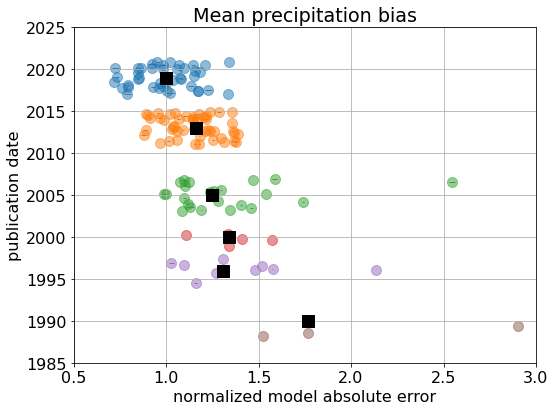

In [38]:
var_key = 'pr_mean_mae'

fig, ax = plt.subplots(1,1,figsize=(8,6))
for key, ens in ens_dict.items():
    
    data = skill_score_dict[key][var_key]
    data_err = skill_score_std_dict[key][var_key]
    ax.errorbar(
        data,
        mip_year_dict[key]*np.ones_like(data) + 4*(np.random.rand(*data.shape)-0.5),
        xerr=data_err,
        linewidth=0., elinewidth=1., ecolor='k',
        marker="o", markersize=10, alpha=0.5, color=mip_col[key], zorder=1
    )

    data = skill_score_dict[key][var_key].median(skipna=True)
    ax.plot(data, mip_year_dict[key]*np.ones_like(data),
         marker='s', markersize=12, color="k", markeredgecolor='k', zorder=2)
    
ax.set_title("Mean precipitation bias")

ax.set_ylim([1985,2025])
ax.set_xlim([0.5, 3.0])
ax.set_ylabel('publication date')
ax.set_xlabel('normalized model absolute error')
ax.grid(True)

plt.tight_layout()
plt.savefig("../figures/model_performance_pr-mae_example.png",bbox_inches='tight',dpi=200)

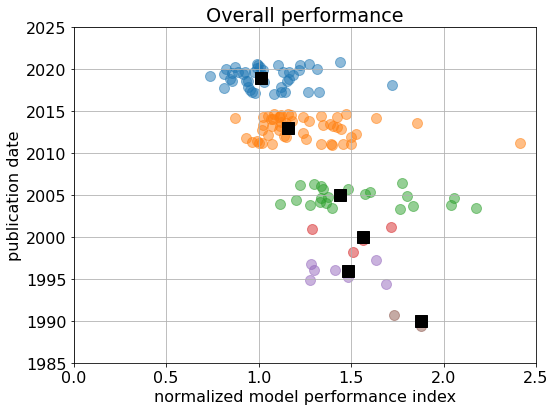

In [67]:
var_key = 'performance'

medians = []
years = []

fig, ax = plt.subplots(1,1,figsize=(8,6))
for key, ens in ens_dict.items():
    
    data = skill_score_dict[key][var_key]
    data_err = skill_score_std_dict[key][var_key]
    ax.errorbar(
        data,
        mip_year_dict[key]*np.ones_like(data) + 4*(np.random.rand(*data.shape)-0.5),
        xerr=data_err,
        linewidth=0., elinewidth=1., ecolor='k',
        marker="o", markersize=10, alpha=0.5, color=mip_col[key], zorder=1
    )

    data = skill_score_dict[key][var_key].median(skipna=True)
    medians.append(data.values)
    years.append(mip_year_dict[key])
    ax.plot(data, mip_year_dict[key]*np.ones_like(data),
         marker='s', markersize=12, color="k", markeredgecolor='k', zorder=2)
    
    
a, b = np.polyfit(years, medians, 1)
x = np.arange(1985., 2100., 1.)
#ax.plot(a*x + b, x, "k--")
    
ax.set_title("Overall performance")

ax.set_ylim([1985,2025])
ax.set_xlim([0., 2.5])
ax.set_ylabel('publication date')
ax.set_xlabel('normalized model performance index')
ax.grid(True)

plt.tight_layout()
plt.savefig("../figures/model_performance_nofit.png",bbox_inches='tight',dpi=200)

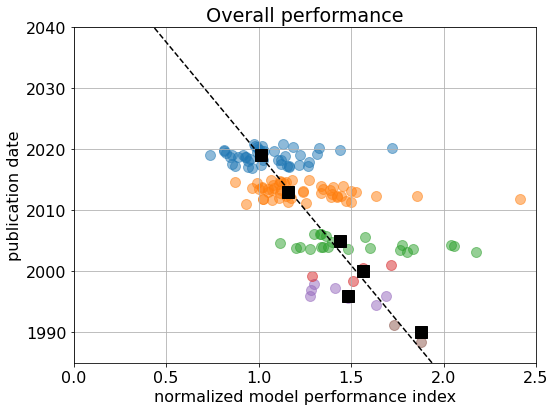

In [68]:
var_key = 'performance'

medians = []
years = []

fig, ax = plt.subplots(1,1,figsize=(8,6))
for key, ens in ens_dict.items():
    
    data = skill_score_dict[key][var_key]
    data_err = skill_score_std_dict[key][var_key]
    ax.errorbar(
        data,
        mip_year_dict[key]*np.ones_like(data) + 4*(np.random.rand(*data.shape)-0.5),
        xerr=data_err,
        linewidth=0., elinewidth=1., ecolor='k',
        marker="o", markersize=10, alpha=0.5, color=mip_col[key], zorder=1
    )

    data = skill_score_dict[key][var_key].median(skipna=True)
    medians.append(data.values)
    years.append(mip_year_dict[key])
    ax.plot(data, mip_year_dict[key]*np.ones_like(data),
         marker='s', markersize=12, color="k", markeredgecolor='k', zorder=2)
    
    
a, b = np.polyfit(years, medians, 1)
x = np.arange(1985., 2100., 1.)
ax.plot(a*x + b, x, "k--")
    
ax.set_title("Overall performance")

ax.set_ylim([1985,2040])
ax.set_xlim([0., 2.5])
ax.set_ylabel('publication date')
ax.set_xlabel('normalized model performance index')
ax.grid(True)

plt.tight_layout()
plt.savefig("../figures/model_performance.png",bbox_inches='tight',dpi=200)

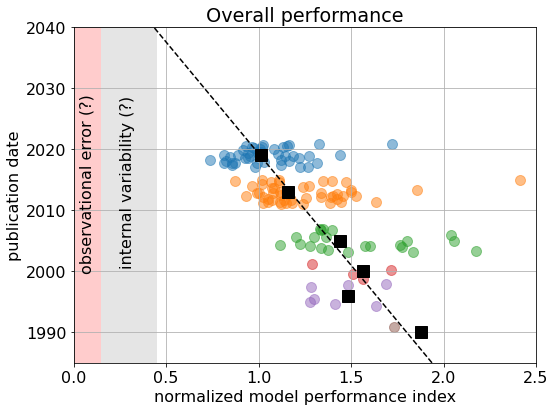

In [69]:
var_key = 'performance'

medians = []
years = []

fig, ax = plt.subplots(1,1,figsize=(8,6))
for key, ens in ens_dict.items():
    
    data = skill_score_dict[key][var_key]
    data_err = skill_score_std_dict[key][var_key]
    ax.errorbar(
        data,
        mip_year_dict[key]*np.ones_like(data) + 4*(np.random.rand(*data.shape)-0.5),
        xerr=data_err,
        linewidth=0., elinewidth=1., ecolor='k',
        marker="o", markersize=10, alpha=0.5, color=mip_col[key], zorder=1
    )

    data = skill_score_dict[key][var_key].median(skipna=True)
    medians.append(data.values)
    years.append(mip_year_dict[key])
    ax.plot(data, mip_year_dict[key]*np.ones_like(data),
         marker='s', markersize=12, color="k", markeredgecolor='k', zorder=2)
    
    
a, b = np.polyfit(years, medians, 1)
x = np.arange(1985., 2100., 1.)
ax.plot(a*x + b, x, "k--")
ax.fill_between([0., 0.15], [1985, 1985], [2040, 2040], facecolor='r', alpha=0.2)
ax.fill_between([0.15, 0.45], [1985, 1985], [2040, 2040], facecolor='grey', alpha=0.2)
    
ax.annotate(s="observational error (?)", xy=(0.03, 2000.25), xycoords='data', rotation=90.)
ax.annotate(s="internal variability (?)", xy=(0.25, 2001), xycoords='data', rotation=90.)

ax.set_title("Overall performance")

ax.set_ylim([1985,2040])
ax.set_xlim([0., 2.5])
ax.set_ylabel('publication date')
ax.set_xlabel('normalized model performance index')
ax.grid(True)

plt.tight_layout()
plt.savefig("../figures/model_performance_uncertainty.png",bbox_inches='tight',dpi=200)

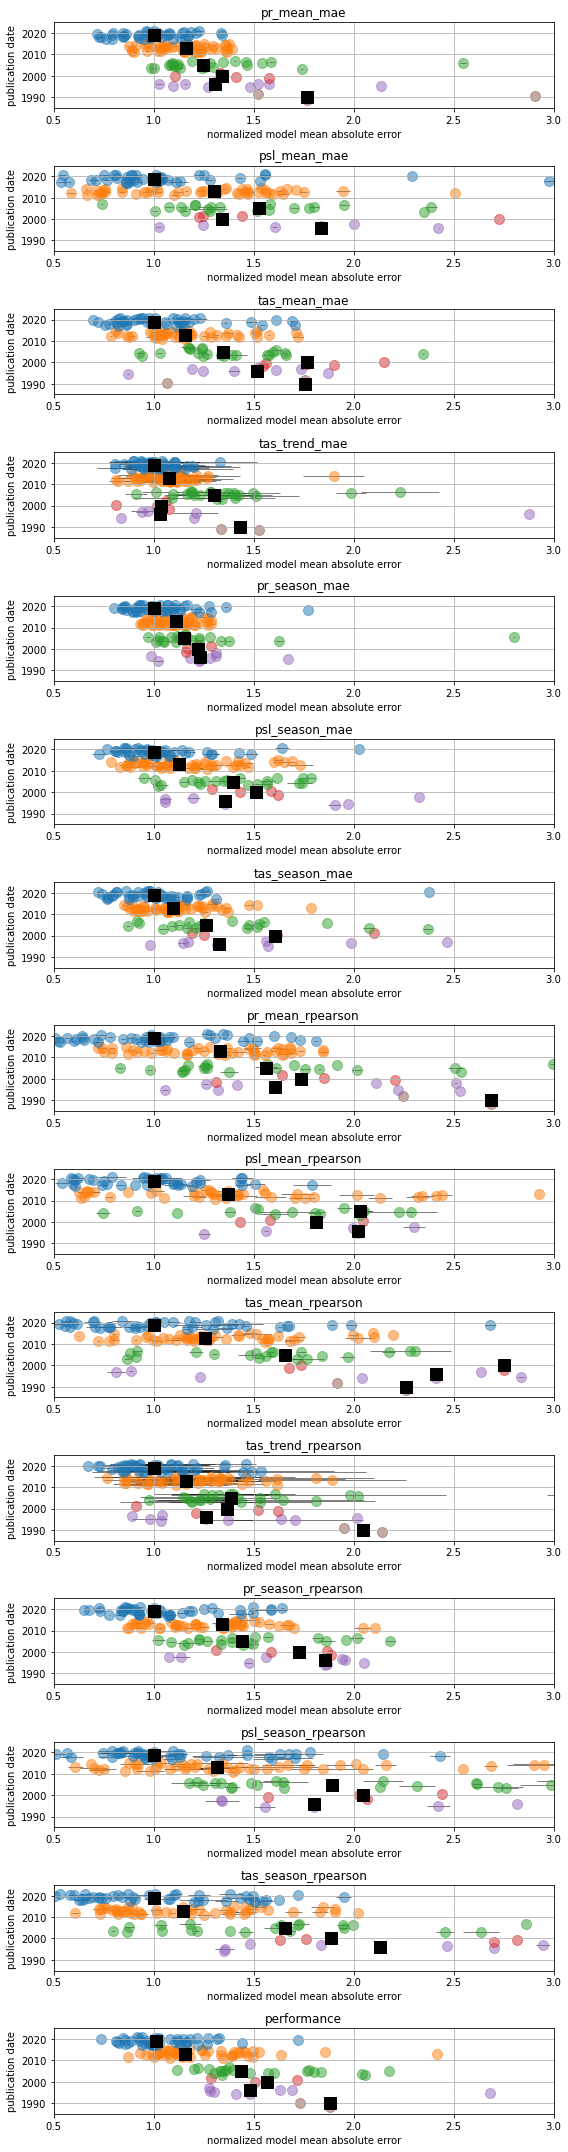

In [37]:
fig, axes = plt.subplots(len(skill_score_dict["cmip6"]),1,figsize=(8,30))

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for idx, var_key in enumerate(skill_score_dict["cmip6"].keys()):
            
        if var_key not in skill_score_dict[key].data_vars: continue
        ax = axes[idx]
        
        data = skill_score_dict[key][var_key]
        data_err = skill_score_std_dict[key][var_key]
        ax.errorbar(
            data,
            mip_year_dict[key]*np.ones_like(data) + 4*(np.random.rand(*data.shape)-0.5),
            xerr=data_err,
            linewidth=0., elinewidth=1., ecolor='k',
            marker="o", markersize=10, alpha=0.5, label=ens_label, color=mip_col[key], zorder=1
        )

        data = skill_score_dict[key][var_key].median(skipna=True)
        ax.plot(data, mip_year_dict[key]*np.ones_like(data),
             marker='s', markersize=12, color="k", markeredgecolor='k', zorder=2)
        
        subplot_count+=1
        ax.set_title(var_key)

for subplot_count, ax in enumerate(axes):

    ax.set_ylim([1985,2025])
    ax.set_xlim([0.5, 3.0])
    ax.set_ylabel('publication date')
    ax.set_xlabel('normalized model mean absolute error')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig("../figures/model_performance_over_time_fullscatter.png",bbox_inches='tight',dpi=100)

In [ ]:
fig, axes = plt.subplots(len(var_shape),1,figsize=(8,30))

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for idx, var_key in enumerate(var_shape.keys()):
        
        if var_key not in rpearson_skill_score_dict[key]: continue
        
        if var_key == 'tas':
            ens_label = key
        else:
            ens_label = None
            
        ax = axes[idx]
        
        data = rpearson_skill_score_dict[key][var_key]
        data_err = rpearson_std_skill_score_dict[key][var_key]
        ax.errorbar(
            data,
            mip_year_dict[key]*np.ones_like(data) + 4*(np.random.rand(*data.shape)-0.5),
            xerr=data_err,
            linewidth=0., elinewidth=1., ecolor='k',
            marker=var_shape[var_key], markersize=10, alpha=0.5, label=ens_label, color=mip_col[key], zorder=1
        )

        data = rpearson_skill_score_dict[key][var_key].median(skipna=True)
        ax.plot(data, mip_year_dict[key]*np.ones_like(data),
             marker='o', markersize=12, color="k", markeredgecolor='k', zorder=2)
        
        subplot_count+=1
        
        ax.set_title(var_key+" performance")
    
#var_longname = ['near-surface air temperature', 'precipitation rate', 'sea level pressure']

for subplot_count, ax in enumerate(axes):

    ax.set_ylim([1985,2025])
    ax.set_xlim([0, 2.5])
    ax.set_ylabel('publication date')
    ax.set_xlabel('normalized model mean absolute error')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig("../figures/model_rpearson_over_time_fullscatter.png",bbox_inches='tight',dpi=100)

### Find outliers

In [ ]:
mae_dict['cmip6']['tas_trend'].argmax()

In [ ]:
mae_dict['cmip6'].ensemble.values[114]

In [ ]:
ens_dict['cmip6']['tas_trend'].sel(ensemble='E3SM-Project-E3SM-1-1-ECA-r1i1p1f1').plot()

In [ ]:
ens_dict['cmip6']['tas_mean'].sel(ensemble='E3SM-Project-E3SM-1-1-ECA-r1i1p1f1').plot()

In [ ]:
(ens_dict['cmip6']['tas_mean'].sel(ensemble='E3SM-Project-E3SM-1-1-ECA-r1i1p1f1') - obs['tas_mean']).plot()

In [ ]:
fig, axes = plt.subplots(len(plot_varnames),1,figsize=(8,12))

ax=axes[0]
ens_mean_label = "ens-mean"
ax.plot([], [], 'k<', markersize=10, label=ens_mean_label)
ax.plot([], [], 'k>', markersize=10, label='ens-median')

ax.plot([], [], 'k', marker=var_shape['tas'], markersize=10, label='tas', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['pr'], markersize=10, label='pr', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['psl'], markersize=10, label='sfcWind', linewidth=0.)

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for idx, var_key in enumerate(var_shape.keys()):
        
        if var_key not in mae_dict[key]: continue
        
        if var_key == 'tas':
            ens_label = key
        else:
            ens_label = None
            
        ax = axes[idx]
        
        data = mae_skill_score_dict[key][var_key]
        data = data[~np.isnan(data)]
        
        alpha=0.75
        markersize=15.
        if data.size > 10:
            alpha=0.4
            markersize=10
            
        ax.plot(
            data,mip_year_dict[key]*np.ones_like(data),
            linewidth=0, marker=".", markersize=markersize, alpha=alpha, color="C0"
        )
        
        if data.size > 10:
            parts = ax.violinplot(
                data[~np.isnan(data)],
                positions=[mip_year_dict[key]],
                widths = 5.,
                vert=False, showextrema=False,
            )

            for pc in parts['bodies']:
                pc.set_facecolor("C0")
                pc.set_edgecolor("k")
                pc.set_alpha(0.3)

        subplot_count+=1
    
var_longname = ['near-surface air temperature', 'precipitation rate', 'sea level pressure']
var_minlim = [0.0, 0.0, 0.0]
var_maxlim = [3.5, 3.5, 3.5]
for subplot_count, ax in enumerate(axes):

    ax.set_ylim([1985,2025])
    ax.set_xlim([var_minlim[subplot_count], var_maxlim[subplot_count]])
    ax.set_ylabel('publication date')
    ax.set_xlabel('normalized model mean absolute error')
    if subplot_count == 0: ax.legend()
    ax.set_title(var_longname[subplot_count]+' performance')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig("../figures/model_performance_over_time_violin.png",bbox_inches='tight',dpi=100)

In [ ]:
mip = 'cmip6'
percent_spread = (mae_dict[mip].groupby('source_id').max() - mae_dict[mip].groupby('source_id').min())/mae_dict[mip].groupby('source_id').mean(skipna=True).compute()
for dv in percent_spread.data_vars:
    percent_spread[dv].loc[percent_spread[dv]==0.] = np.nan

In [ ]:
plt.plot(percent_spread['pr_mean'].values, "o", label='pr')
plt.plot(percent_spread['tas_mean'].values, "o", label='tas')
plt.plot(percent_spread['psl_mean'].values, "o", label='psl')
plt.xticks(np.arange(0, len(percent_spread.source_id.values)), percent_spread.source_id.values, rotation=90)
plt.legend()

In [ ]:
q = (ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r3i1p1f1')['pr_mean']).plot()
#q.set_clim([0., 1.e-4])

In [ ]:
q = obs['pr_mean'].plot()
q.set_clim([0., 1.e-4])

In [ ]:
q = ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r2i1p1f1')['pr_mean'].plot()
q.set_clim([0., 1.e-4])

In [ ]:
(ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r2i1p1f1')['pr'] - ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r3i1p1f1')['pr']).plot()